In [1]:
path_data = '../../data/'

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import warnings
warnings.filterwarnings('ignore')

In [2]:
def standard_units(any_numbers):
    "Convert any array of numbers to standard units."
    return (any_numbers - np.mean(any_numbers))/np.std(any_numbers)  

def correlation(t, x, y):
    return np.mean(standard_units(t[x])*standard_units(t[y]))

Now that we have explored ways to use multiple attributes to predict a categorical variable, let us return to predicting a quantitative variable. Predicting a numerical quantity is called regression, and a commonly used method to use multiple attributes for regression is called *multiple linear regression*.

# Home Prices

The following dataset of house prices and attributes was collected over several years for the city of Ames, Iowa. A [description of the dataset appears online](http://ww2.amstat.org/publications/jse/v19n3/decock.pdf). We will focus only a subset of the columns. We will try to predict the sale price column from the other columns.

In [3]:
all_sales = pd.read_csv(path_data + 'house.csv')

len(all_sales)

2930

In [4]:
sales1 = all_sales[all_sales['Bldg Type'] == '1Fam']
sales2 = sales1[all_sales['Sale Condition'] == 'Normal']

sales = sales2[['SalePrice', '1st Flr SF', '2nd Flr SF', 
    'Total Bsmt SF', 'Garage Area', 
    'Wood Deck SF', 'Open Porch SF', 'Lot Area', 
    'Year Built', 'Yr Sold']]

sales = sales.sort_values(by=['SalePrice'])

len(sales)

2002

A histogram of sale prices shows a large amount of variability and a distribution that is clearly not normal. A long tail to the right contains a few houses that had very high prices. The short left tail does not contain any houses that sold for less than $35,000.

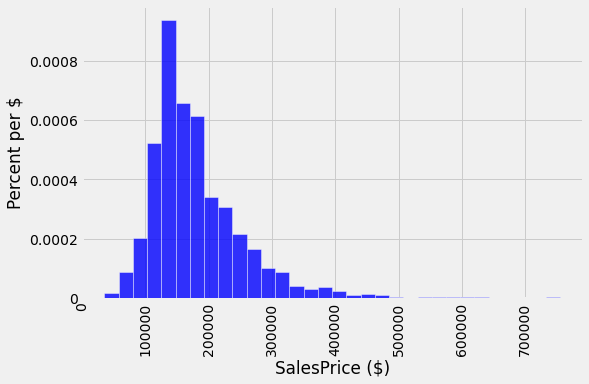

In [5]:
unit = '$'

fig, ax = plt.subplots(figsize=(8,5))

ax.hist(sales['SalePrice'], bins=32, density=True, color='blue', alpha=0.8, ec='white', zorder=5)

y_vals = ax.get_yticks()

y_label = 'Percent per ' + (unit if unit else 'unit')

x_label = 'SalesPrice ($)' 

ax.set_yticklabels(['{:g}'.format(x * 100) for x in y_vals])

plt.ylabel(y_label)

plt.xlabel(x_label)

plt.xticks(rotation=90)

plt.title('');

plt.show()

## Correlation

No single attribute is sufficient to predict the sale price. For example, the area of first floor, measured in square feet, correlates with sale price but only explains some of its variability.

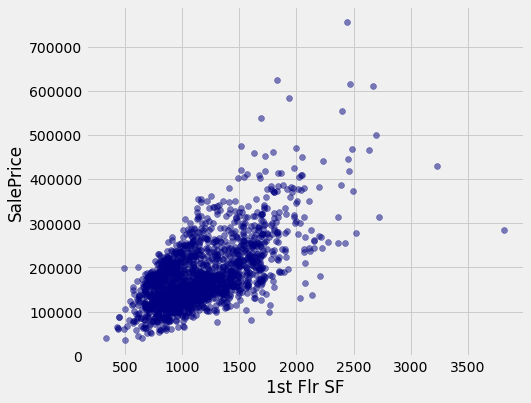

In [6]:
fig, ax = plt.subplots(figsize=(7,6))

ax.scatter(sales['1st Flr SF'], 
           sales['SalePrice'],   
           color='navy', 
          alpha=0.5)

x_label = '1st Flr SF'

y_label = 'SalePrice'

plt.ylabel(y_label)

plt.xlabel(x_label)

plt.show()

In [7]:
correlation(sales, 'SalePrice', '1st Flr SF')

0.6424662541030226

In fact, none of the individual attributes have a correlation with sale price that is above 0.7 (except for the sale price itself).

In [8]:
for label in sales.columns:
    print('Correlation of', label, 'and SalePrice:\t', correlation(sales, label, 'SalePrice'))

Correlation of SalePrice and SalePrice:	 1.0000000000000018
Correlation of 1st Flr SF and SalePrice:	 0.6424662541030226
Correlation of 2nd Flr SF and SalePrice:	 0.35752189428008124
Correlation of Total Bsmt SF and SalePrice:	 0.6529786267571697
Correlation of Garage Area and SalePrice:	 0.6385944852520441
Correlation of Wood Deck SF and SalePrice:	 0.352698666195049
Correlation of Open Porch SF and SalePrice:	 0.33690941702637345
Correlation of Lot Area and SalePrice:	 0.29082345511576896
Correlation of Year Built and SalePrice:	 0.565164753713592
Correlation of Yr Sold and SalePrice:	 0.025948579080721384


However, combining attributes can provide higher correlation. In particular, if we sum the first floor and second floor areas, the result has a higher correlation than any single attribute alone.

In [9]:
sales_copy = sales.copy()

both_floors = sales_copy.iloc[:,1] + sales_copy.iloc[:,2]

sales_copy['Both Floors'] = both_floors

correlation(sales_copy, 'SalePrice', 'Both Floors')

0.7821920556134886

This high correlation indicates that we should try to use more than one attribute to predict the sale price. In a dataset with multiple observed attributes and a single numerical value to be predicted (the sale price in this case), multiple linear regression can be an effective technique.

## Multiple Linear Regression 

In multiple linear regression, a numerical output is predicted from numerical input attributes by multiplying each attribute value by a different slope, then summing the results. In this example, the slope for the `1st Flr SF` would represent the dollars per square foot of area on the first floor of the house that should be used in our prediction. 

Before we begin prediction, we split our data randomly into a training and test set of equal size.

### Train / Test split

In [10]:
sales_copy = sales.copy()
train = sales_copy.sample(1001, replace=False)
test = sales_copy.drop(train.index)

print(len(train), 'training and', len(test), 'test instances.')

1001 training and 1001 test instances.


### define function to create train, test split

In [11]:
def split(self, k):
    if not 1 <= k <= (len(self) - 1):
        raise ValueError("Invalid value of k. k must be between 1 and the"
                         "number of rows - 1")

    rows = np.random.permutation(len(self))

    first = self.take(rows[:k])
    rest = self.take(rows[k:])

    return first, rest

train, test = split(sales, 1001)

print(len(train), 'training and', len(test), 'test instances.')

1001 training and 1001 test instances.


### Alternative - scikit learn
as an aside we could emplot the `scikit learn` function to determine the `train, test split`.

[sklearn.model_selection.train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html#sklearn-model-selection-train-test-split)

In [12]:
import numpy as np
from sklearn.model_selection import train_test_split

train, test = train_test_split(sales_copy, test_size=0.5)

print(len(train), 'training and', len(test), 'test instances.')

1001 training and 1001 test instances.


The slopes in multiple regression is an array that has one slope value for each attribute in an example. Predicting the sale price involves multiplying each attribute by the slope and summing the result.

In [13]:
def predict(slopes, row):
    return sum(slopes * np.array(row))

example_row1 = test.drop(columns=['SalePrice'])
example_row = example_row1.iloc[0]

print('Predicting sale price for:')
print(example_row)

example_slopes = np.random.normal(10, 1, len(example_row))

print('\nUsing slopes:\n', example_slopes)

print('\nResult:', predict(example_slopes, example_row))

Predicting sale price for:
1st Flr SF        1244.0
2nd Flr SF           0.0
Total Bsmt SF     1244.0
Garage Area        336.0
Wood Deck SF         0.0
Open Porch SF       40.0
Lot Area         11988.0
Year Built        1957.0
Yr Sold           2007.0
Name: 1922, dtype: float64

Using slopes:
 [10.66266607 11.04000738 11.05823199  9.70462703  8.84114377  9.56944347
 11.61432997 10.37252802 11.38349509]

Result: 213042.62920044773


The result is an estimated sale price, which can be compared to the actual sale price to assess whether the slopes provide accurate predictions. Since the `example_slopes` above were chosen at random, we should not expect them to provide accurate predictions at all.

In [14]:
print('Actual sale price:', test['SalePrice'].iloc[0])
print('Predicted sale price using random slopes:', predict(example_slopes, example_row))

Actual sale price: 150000
Predicted sale price using random slopes: 213042.62920044773


## Least Squares Regression
The next step in performing multiple regression is to define the least squares objective. We perform the prediction for each row in the training set, and then compute the root mean squared error (RMSE) of the predictions from the actual prices.

In [15]:
train_prices = train.iloc[:,0]
train1 = train.copy()
train_attributes = train1.drop(train1.columns[0], axis=1)

def rmse(slopes, attributes, prices):
    errors = []
    for i in np.arange(len(prices)):
        predicted = predict(slopes, attributes.iloc[i])
        actual = prices.iloc[i]
        errors.append((predicted - actual) ** 2)
    return np.mean(errors) ** 0.5

def rmse_train(slopes):
    return rmse(slopes, train_attributes, train_prices)

print('RMSE of all training examples using random slopes:', rmse_train(example_slopes))

RMSE of all training examples using random slopes: 114914.11566039815


Finally, we use the `minimize` function to find the slopes with the lowest RMSE. Since the function we want to minimize, `rmse_train`, takes an array instead of a number, we must pass the `array=True` argument to `minimize`. When this argument is used, `minimize` also requires an initial guess of the slopes so that it knows the dimension of the input array. Finally, to speed up optimization, we indicate that `rmse_train` is a smooth function using the `smooth=True` attribute. Computation of the best slopes may take several minutes.

[scipy optimize.minimize](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html)

In [16]:
from scipy import optimize

def minimize(f, start=None, smooth=False, log=None, array=False, **vargs):
    """Minimize a function f of one or more arguments.
    Args:
        f: A function that takes numbers and returns a number
        start: A starting value or list of starting values
        smooth: Whether to assume that f is smooth and use first-order info
        log: Logging function called on the result of optimization (e.g. print)
        vargs: Other named arguments passed to scipy.optimize.minimize
    Returns either:
        (a) the minimizing argument of a one-argument function
        (b) an array of minimizing arguments of a multi-argument function
    """
    if start is None:
        assert not array, "Please pass starting values explicitly when array=True"
        arg_count = f.__code__.co_argcount
        assert arg_count > 0, "Please pass starting values explicitly for variadic functions"
        start = [0] * arg_count
    if not hasattr(start, '__len__'):
        start = [start]

    if array:
        objective = f
    else:
        @functools.wraps(f)
        def objective(args):
            return f(*args)

    if not smooth and 'method' not in vargs:
        vargs['method'] = 'Powell'
    result = optimize.minimize(objective, start, **vargs)
    if log is not None:
        log(result)
    if len(start) == 1:
        return result.x.item(0)
    else:
        return result.x

In [17]:
best_slopes = minimize(rmse_train, start=example_slopes, smooth=True, array=True)
 
train_df = pd.DataFrame(columns=[train_attributes.columns])

train_df.loc[0] = best_slopes

print('The best slopes for the training set:')

train_df

The best slopes for the training set:


1st Flr SF 2nd Flr SF Total Bsmt SF Garage Area Wood Deck SF Open Porch SF  \
0  78.980021  75.902626     48.804937    48.98349    45.186775      7.047521   

   Lot Area  Year Built     Yr Sold  
0  0.435624  538.362254 -537.790128

In [18]:
print('RMSE of all training examples using the best slopes:', rmse_train(best_slopes))

RMSE of all training examples using the best slopes: 34594.95413398824


### Interpreting Multiple Regression 
Let's interpret these results. The best slopes give us a method for estimating the price of a house from its attributes. A square foot of area on the first floor is worth about \$75 (the first slope), while one on the second floor is worth about \\$70 (the second slope). The final negative value describes the market: prices in later years were lower on average.

The RMSE of around \\$30,000 means that our best linear prediction of the sale price based on all of the attributes is off by around \\$30,000 on the training set, on average.  We find a similar error when predicting prices on the test set, which indicates that our prediction method will generalize to other samples from the same population.

In [19]:
test_prices = test.iloc[:,0]

test_attributes = test.drop(test.columns[0], axis=1)
test_attributes.head(2)

1st Flr SF  2nd Flr SF  Total Bsmt SF  Garage Area  Wood Deck SF  \
1922        1244           0         1244.0        336.0             0   
685          832         629          832.0        384.0             0   

      Open Porch SF  Lot Area  Year Built  Yr Sold  
1922             40     11988        1957     2007  
685             204     10800        1949     2009

In [20]:
test_prices = test.iloc[:,0]
test_attributes = test.drop(test.columns[0], axis=1)

def rmse_test(slopes):
    return rmse(slopes, test_attributes, test_prices)

rmse_linear = rmse_test(best_slopes)
print('Test set RMSE for multiple linear regression:', rmse_linear)

Test set RMSE for multiple linear regression: 27254.40534406947


If the predictions were perfect, then a scatter plot of the predicted and actual values would be a straight line with slope 1. We see that most dots fall near that line, but there is some error in the predictions.

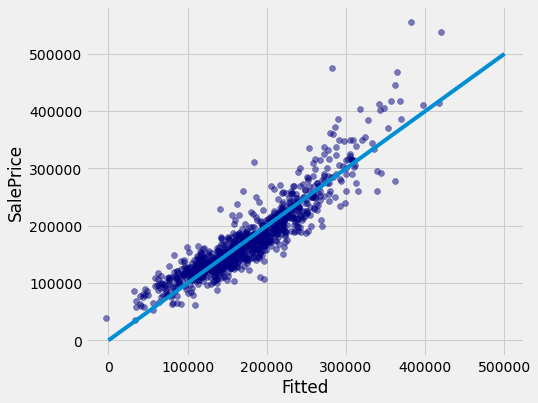

In [21]:
def fit(row):
    return sum(best_slopes * np.array(row))

test['Fitted'] = test_attributes.apply(fit, axis=1)

fig, ax = plt.subplots(figsize=(7,6))

ax.scatter(test['Fitted'], 
           test['SalePrice'],   
           color='navy', 
          alpha=0.5)

x_label = 'Fitted'

y_label = 'SalePrice'

plt.ylabel(y_label)

plt.xlabel(x_label)

plt.plot([0, 5e5], [0, 5e5])

plt.show()


A residual plot for multiple regression typically compares the errors (residuals) to the actual values of the predicted variable. We see in the residual plot below that we have systematically underestimated the value of expensive houses, shown by the many positive residual values on the right side of the graph.

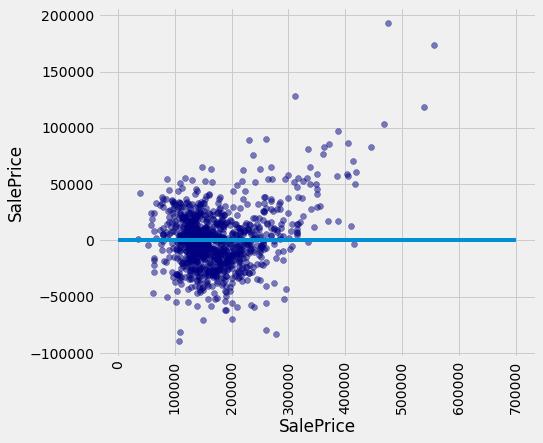

In [22]:
test['Residual'] = test_prices-test_attributes.apply(fit, axis=1)

fig, ax = plt.subplots(figsize=(7,6))

ax.scatter(test['SalePrice'], 
           test['Residual'],   
           color='navy', 
          alpha=0.5)

x_label = 'SalePrice'

y_label = 'SalePrice'

plt.ylabel(y_label)

plt.xlabel(x_label)

plt.xticks(rotation=90)

plt.plot([0, 7e5], [0, 0])

plt.show()

As with simple linear regression, interpreting the result of a predictor is at least as important as making predictions. There are many lessons about interpreting multiple regression that are not included in this textbook. A natural next step after completing this text would be to study linear modeling and regression in further depth.

## Nearest Neighbors for Regression
Another approach to predicting the sale price of a house is to use the price of similar houses. This *nearest neighbor* approach is very similar to our classifier. To speed up computation, we will only use the attributes that had the highest correlation with the sale price in our original analysis.

In [23]:
train_nn = train.iloc[:,[0, 1, 2, 3, 4, 8]]
test_nn = test.iloc[:,[0, 1, 2, 3, 4, 8]]
train_nn.head(3)

SalePrice  1st Flr SF  2nd Flr SF  Total Bsmt SF  Garage Area  \
1137     173000         798         842          798.0        520.0   
437      255500        1717           0         1709.0        908.0   
2598      68000         715           0          715.0        660.0   

      Year Built  
1137        2004  
437         2006  
2598        1929

The computation of closest neighbors is identical to a nearest-neighbor classifier. In this case, we will exclude the `'SalePrice'` rather than the `'Class'` column from the distance computation. The five nearest neighbors of the first test row are shown below.

In [24]:
def distance(pt1, pt2):
    """The distance between two points, represented as arrays."""
    return np.sqrt(np.sum((pt1 - pt2) ** 2))
    
def row_distance(row1, row2):
    """The distance between two rows of a table."""
    return distance(np.array(row1), np.array(row2))

def distances(training, example, output):
    """Compute the distance from example for each row in training."""
    dists = []
    attributes = training.drop(columns=[output])
    for row in range(len(attributes)):
        dists.append(row_distance(attributes.iloc[row], example))
    training['Distance'] = dists
    #print(training)
    return training

def closest(training, example, k, output):
    """Return a table of the k closest neighbors to example."""
    distance = distances(training, example, output).sort_values(by=['Distance']).take(np.arange(k))
    return distance

train_nn_A = train_nn.copy()
example_nn_row = test_nn.drop(test_nn.columns[0], axis=1).iloc[0]
closest(train_nn_A, example_nn_row, 5, 'SalePrice')

SalePrice  1st Flr SF  2nd Flr SF  Total Bsmt SF  Garage Area  \
1929     129500        1216           0         1216.0        336.0   
1272     155000        1269           0         1269.0        308.0   
1875     143000        1214           0         1214.0        318.0   
1944     156000        1216           0         1216.0        371.0   
146      108538        1206           0         1206.0        312.0   

      Year Built   Distance  
1929        1955  39.648455  
1272        1960  45.199558  
1875        1967  47.159304  
1944        1953  53.000000  
146         1959  58.889727

One simple method for predicting the price is to average the prices of the nearest neighbors.

In [25]:
example_nn_row

1st Flr SF       1244.0
2nd Flr SF          0.0
Total Bsmt SF    1244.0
Garage Area       336.0
Year Built       1957.0
Name: 1922, dtype: float64

In [26]:
def predict_nn(example):
    """Return the majority class among the k nearest neighbors."""
    train_nn_B = train_nn.copy()
    
    col_sales_price = closest(train_nn_B, example, 5, 'SalePrice')
    return np.average(col_sales_price['SalePrice'])

predict_nn(example_nn_row)

138407.6

Finally, we can inspect whether our prediction is close to the true sale price for our one test example. Looks reasonable!

In [27]:
print('Actual sale price:', test_nn['SalePrice'].iloc[0])

print('Predicted sale price using nearest neighbors:', predict_nn(example_nn_row))

Actual sale price: 150000
Predicted sale price using nearest neighbors: 138407.6


### Evaluation

To evaluate the performance of this approach for the whole test set, we apply `predict_nn` to each test example, then compute the root mean squared error of the predictions. Computation of the predictions may take several minutes.

In [28]:
def predict_nn(example):
    """Return the majority class among the k nearest neighbors."""
    train_nn_B = train_nn.copy()
    
    col_sales_price = closest(train_nn_B, example, 5, 'SalePrice')
    return np.average(col_sales_price['SalePrice'])

predict_nn(example_nn_row)

138407.6

In [29]:
test_nn_C = test_nn.copy()

test_nn_drop = test_nn_C.drop(columns=['SalePrice'])

nn_test_predictions = test_nn_drop.apply(predict_nn, axis=1)

rmse_nn = np.mean((test_prices - nn_test_predictions) ** 2) ** 0.5

print('Test set RMSE for multiple linear regression: ', rmse_linear)
print('Test set RMSE for nearest neighbor regression:', rmse_nn)

Test set RMSE for multiple linear regression:  27254.40534406947
Test set RMSE for nearest neighbor regression: 28324.30879280499


For these data, the errors of the two techniques are quite similar! For different data sets, one technique might outperform another. By computing the RMSE of both techniques on the same data, we can compare methods fairly. One note of caution: the difference in performance might not be due to the technique at all; it might be due to the random variation due to sampling the training and test sets in the first place.

Finally, we can draw a residual plot for these predictions. We still underestimate the prices of the most expensive houses, but the bias does not appear to be as systematic. However, fewer residuals are very close to zero, indicating that fewer prices were predicted with very high accuracy. 

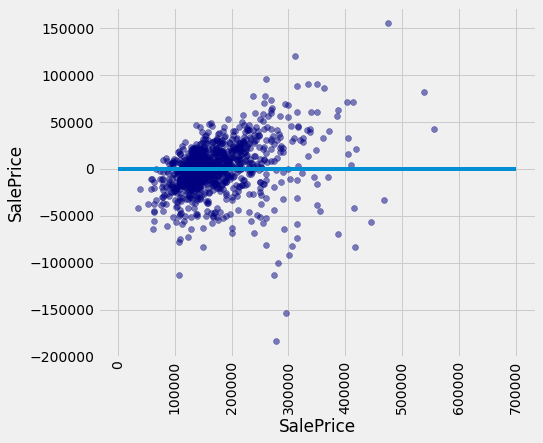

In [30]:
test['Residual'] = test_prices-nn_test_predictions

fig, ax = plt.subplots(figsize=(7,6))

ax.scatter(test['SalePrice'], 
           test['Residual'],   
           color='navy', 
          alpha=0.5)

x_label = 'SalePrice'

y_label = 'SalePrice'

plt.ylabel(y_label)

plt.xlabel(x_label)

plt.xticks(rotation=90)

plt.plot([0, 7e5], [0, 0])

plt.show()